# Dispersion fitting tool

Here we show how to fit optical measurement data and use the results to create dispersion material models for Tidy3d.

Tidy3D's dispersion fitting tool peforms an optimization to find a medium defined as a dispersive [PoleResidue](../generated/tidy3d.PoleResidue.rst) model that minimizes the RMS error between the model results and the data. This can then be directly used as a material in simulations.

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

# first import packages
import matplotlib.pylab as plt
import numpy as np

import sys
sys.path.append('..')
import tidy3d as td

## Load Data

The fitting tool accepts numpy arrays for the data points, but if we have a data file instead, we can load that with the `load_nk_file` utility function.

Our data file has columns for wavelength (um), real part of refractive index (n), and imaginary part of refractive index (k).  k data is optional.

Note: `load_nk_file` uses [np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) under the hood, so additional keyword arguments for parsing the file follow the same format as [np.loadtxt](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html).

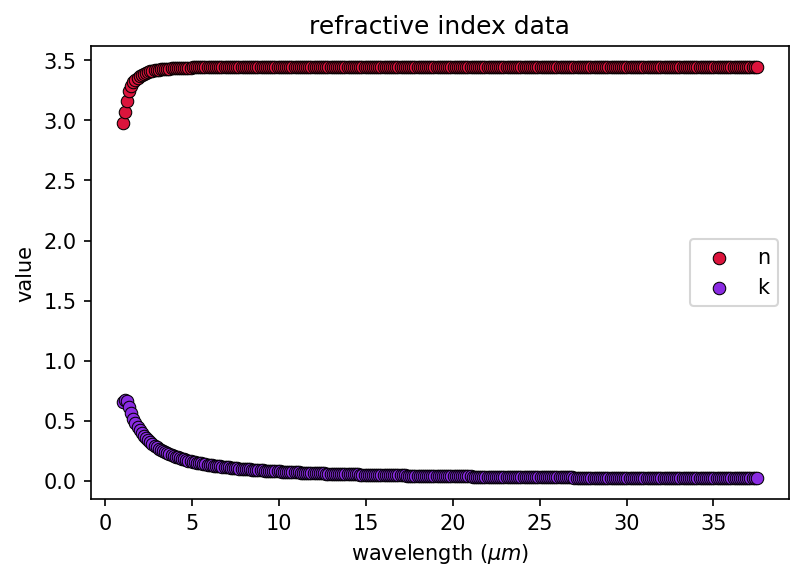

In [2]:
from tidy3d.plugins import DispersionFitter

fname = 'data/nk_data.csv'

# note that additional keyword arguments to load_nk_file get passed to np.loadtxt
fitter = DispersionFitter.load(fname, skiprows=1, delimiter=',')

# lets plot the data
plt.scatter(fitter.wvl_um, fitter.n_data, label='n', color='crimson', edgecolors='black', linewidth=0.5)
plt.scatter(fitter.wvl_um, fitter.k_data, label='k', color='blueviolet', edgecolors='black', linewidth=0.5)
plt.xlabel('wavelength ($\mu m$)')
plt.ylabel('value')
plt.title('refractive index data')
plt.legend()
plt.show()

## Fitting the data

The fitting tool uses the [nlopt](https://github.com/stevengj/nlopt) package to fit a dispersion model to the data by minimizing the root mean squared (RMS) error between the model n,k prediciton and the data at the given wavelengths.

There are various fitting parameters that can be set, but the most important is the number of "poles" in the model.

For each pole, there are 4 degrees of freedom in the model.  Adding more poles can produce a closer fit, but each additional pole added will make the fit harder to obtain and will slow down the FDTD.  Therefore, it is best to try the fit with few numbers of poles and increase until the results look good.

Here, we will first try fitting the data with 1 pole and specify the RMS value that we are happy with (`tolerance_rms`).

Note that the fitting tool performs global optimizations with random starting coefficients, and will repeat the optimization `num_tries` times, returning either the best result or the first result to satisfy the tolerance specified.

In [3]:
medium, rms_error = fitter.fit(
                        num_poles=1,
                        tolerance_rms=1e-2,
                        num_tries=100)

Output()

[16:41:01] WARNING          warning: did not find fit with RMS error under         ]8;id=813659;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/plugins/dispersion/fit.py\fit.py]8;;\:235
                    tolerance_rms of 1.00e-02

           INFO             returning best fit with RMS error 9.95e-02             ]8;id=882092;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/plugins/dispersion/fit.py\fit.py]8;;\:239

The RMS error stalled at a value that was far above our tolerance, so we might want to try more fits.

Let's first visualize how well the best single pole fit captured our model using the `.plot()` method

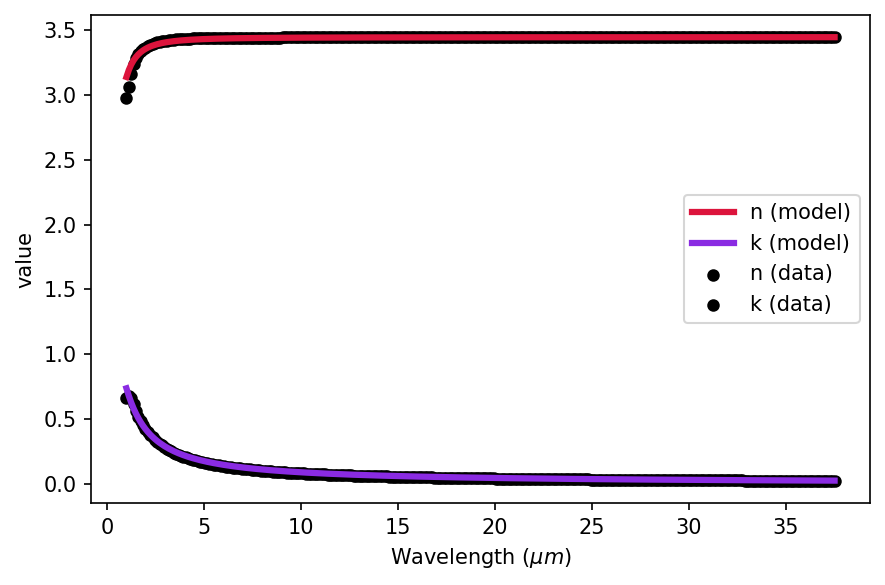

In [4]:
fitter.plot(medium)
plt.show()

As we can see, there is room for improvement at short wavelengths. Let's now try a two pole fit.

In [5]:
medium, rms_error = fitter.fit(
                        num_poles=2,
                        tolerance_rms=2e-2,
                        num_tries=50)

Output()

[16:41:03] INFO             found optimal fit with RMS error = 1.59e-02, returning ]8;id=363497;file:///Users/twhughes/Documents/Flexcompute/Tidy3D-client-revamp/notebooks/../tidy3d/plugins/dispersion/fit.py\fit.py]8;;\:231

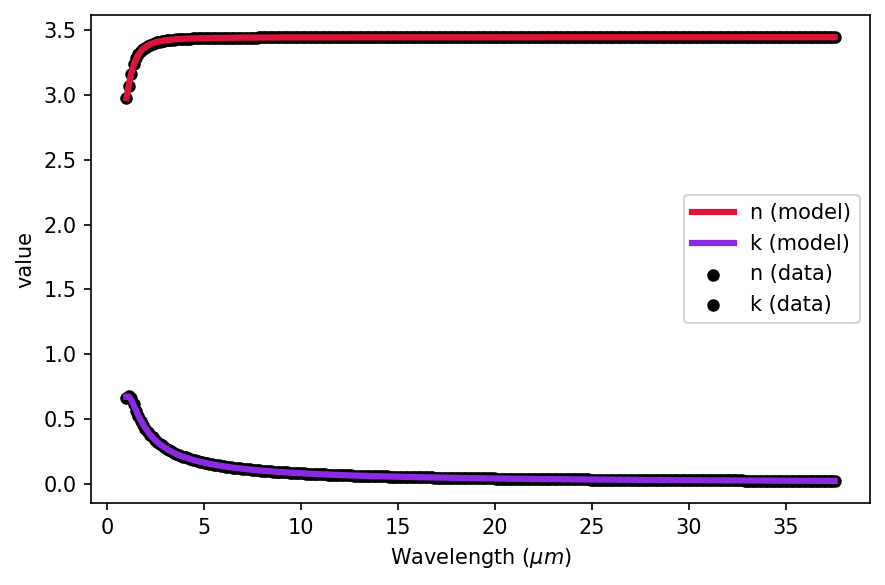

In [6]:
fitter.plot(medium)
plt.show()

This fit looks great and should be sufficient for our simulation.

## Using Fit Results

With the fit performed, we want to use the `Medium` in our simulation.


### Method 1: direct export as Medium

The fit returns a medium, which can be used directly in simulation

In [7]:
b = td.Structure(
    geometry=td.Box(size=(1,1,1)),
    medium=medium)

### Method 2: print medium definition string

In many cases, one may want to perform the fit once and then hardcode the result in their tidy3d script.

For a quick and easy way to do this, just `print()` the medium and the output can be copied and pasted into your main svript

In [8]:
print(medium)

td.PoleResidue(
	poles=[((-68165393701.49064, 5761790391964051.0), (292728598971448.75, -1.759464659235666e+16)), ((-1306364659119320.8, -1592663212303188.5), (8437328245819.594, 6351306721917254.0))], 
	frequency_range=(7994465562158.582, 299792458580946.8))


In [9]:
# medium = td.PoleResidue(
# 	poles=[((-1720022108564405.2, 1111614865738177.4), (1.0199002935090378e+16, -3696384150818460.5)), ((0.0, -3100558969639478.5), (3298054971521434.5, 859192377978951.2))], 
# 	frequency_range=(7994465562158.582, 299792458580946.8))

### Method 3: save and load file containing poles

Finally, one can save export the `Medium` directly as .json file. Here is an example.

In [10]:
# save poles to pole_data.txt
fname = 'data/my_medium.json'
medium.export(fname)

# load the file in your script
medium = td.PoleResidue.load(fname)

## Tricks and Tips / Troubleshooting

Performing dispersion model fits is more of an art than a science and some trial and error may be required to get good fits.  A good general strategy is to:

- Start with few poles and increase unitl RMS error gets to the desired level.

- Large `num_tries` values can sometimes find good fits if the RMS seems stalled.  it can be a good idea to set a large number of tries and let it run for a while on an especially difficult data model.

- Tailor the parameters to your data.  Long wavelengths and large n,k values can affect the RMS error that is considered a 'good' fit.  So it is a good idea to tweak the tolerance to match your data.  Once size does not fit all.

Finally, there are some things to be aware of when troubleshooting the dispersion models in your actaual simulation:

- It is common to find divergence in FDTD simulations due to dispersive materials.  Besides trying "absorber" PML types and reducing runtime, a good solution can be to try other fits.  Therefore, if a simulation is diverging with a single fit result, it is often worth fitting a few more times and trying those results.

- If you are unable to find a good fit to your data, it might be worth considering whether you care about certain features in the data.  For example, if the simulation is narrowband, you might want to truncate your data to not include wavelengths far ourside your measurement wavelength to simplify the dispersive model.